## Sequence Models - Week 1 - Andrew Ng
### Character level language model - Dinosaurus Island
Welcome to Dinosaurus Island! 65 million years ago, dinosaurs existed, and in this assignment they are back. You are in charge of a special task. Leading biology researchers are creating new breeds of dinosaurs and bringing them to life on earth, and your job is to give names to these dinosaurs. If a dinosaur does not like its name, it might go berserk, so choose wisely!

Luckily you have learned some deep learning and you will use it to save the day. Your assistant has collected a list of all the dinosaur names they could find, and compiled them into this dataset. (Feel free to take a look by clicking the previous link.) To create new dinosaur names, you will build a character level language model to generate new names. Your algorithm will learn the different name patterns, and randomly generate new names. Hopefully this algorithm will keep you and your team safe from the dinosaurs' wrath!

By completing this assignment you will learn:

* How to store text data for processing using an RNN
* How to synthesize data, by sampling predictions at each time step and passing it to the next RNN-cell unit
* How to build a character-level text generation recurrent neural network
* Why clipping the gradients is important

We will begin by loading in some functions that we have provided for you in rnn_utils. Specifically, you have access to functions such as rnn_forward and rnn_backward which are equivalent to those you've implemented in the previous assignment.

In [1]:
import numpy as np
import random

In [2]:
data = open('dinos.txt', 'r').read()

In [3]:
data[:100]

'Aachenosaurus\nAardonyx\nAbdallahsaurus\nAbelisaurus\nAbrictosaurus\nAbrosaurus\nAbydosaurus\nAcanthopholis'

In [4]:
dinos_names = data.split('\n')
print('There are %d dinosaur names. The first 15 names are:' % len(dinos_names))
print(dinos_names[:15])

There are 1536 dinosaur names. The first 15 names are:
['Aachenosaurus', 'Aardonyx', 'Abdallahsaurus', 'Abelisaurus', 'Abrictosaurus', 'Abrosaurus', 'Abydosaurus', 'Acanthopholis', 'Achelousaurus', 'Acheroraptor', 'Achillesaurus', 'Achillobator', 'Acristavus', 'Acrocanthosaurus', 'Acrotholus']


In [5]:
data = data.lower()
chars = list(set(data))

In [6]:
data_size, vocab_size = len(data), len(chars)
print('There are %d total characters and %d unique characters in your data.' % (data_size, vocab_size))

There are 19909 total characters and 27 unique characters in your data.


* The characters are a-z (26 characters) plus the "\n" (or newline character)
* The newline character "\n" plays a role similar to the <EOS> (or "End of sentence") token, discussed in lecture. Here, "\n" indicates the end of the dinosaur name rather than the end of a sentence.
* char_to_ix: a dictionary to map each character to an index from 0-26.
* ix_to_char: a dictionary that maps each index back to the corresponding character. This will help you figure out what index corresponds to what character in the probability distribution output of the softmax layer.

In [7]:
chars = sorted(chars)
print(chars)

['\n', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [8]:
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

### Utilities Functions

In [31]:
def softmax(x):
    ex = np.exp(x - np.max(x))
    return ex / np.sum(ex, axis=0)

def smooth(loss, cur_loss):
    return loss * 0.999 + cur_loss * 0.001

def get_sample(sample_idx, idx_to_char):
    txt = ''.join(idx_to_char[idx] for idx in sample_idx)
    # capitalize the first character
    txt = txt[0].upper() + txt[1:]
    return txt

def print_sample(sample_idx, idx_to_char):
    txt = get_sample(sample_idx, idx_to_char)
    print('%s' % (txt, ), end='')

def get_initial_loss(vocab_size, seq_length):
    return -np.log(1.0/vocab_size) * seq_length

def initialize_parameters(n_a, n_x, n_y):
    np.random.seed(1)
    Wax = np.random.randn(n_a, n_x) * 0.01
    Waa = np.random.randn(n_a, n_a) * 0.01
    Wya = np.random.randn(n_y, n_a) * 0.01
    b = np.zeros((n_a, 1))
    by = np.zeros((n_y, 1))
    params = {'Wax': Wax, 'Waa': Waa, 'Wya': Wya, 'b': b, 'by': by}
    return params

def rnn_step_forward(params, a_prev, x):
    Wax, Waa, Wya, by, b = params['Wax'], params['Waa'], params['Wya'], params['by'], params['b']
    a_next = np.tanh(np.dot(Wax, x) + np.dot(Waa, a_prev) + b)
    # probabilities for next chars
    pt = softmax(np.dot(Wya, a_next) + by)
    return a_next, pt

def rnn_step_backward(dy, grads, params, x, a, a_prev):
    grads['dWya'] += np.dot(dy, a.T)
    grads['dby'] += dy
    da = np.dot(params['Wya'].T, dy) + grads['da_next']
    daraw = (1 - a * a) * da
    grads['db'] += daraw
    grads['dWax'] += np.dot(daraw, x.T)
    grads['dWaa'] += np.dot(daraw, a_prev.T)
    grads['da_next'] = np.dot(params['Waa'].T, daraw)
    return grads

def update_parameters(params, grads, lr):
    params['Wax'] += -lr * grads['dWax']
    params['Waa'] += -lr * grads['dWaa']
    params['Wya'] += -lr * grads['dWya']
    params['b'] += -lr * grads['db']
    params['by'] += -lr * grads['dby']
    return params

def rnn_forward(X, Y, a0, params, vocab_size = 27):
    x, a, y_hat = {}, {}, {}  
    a[-1] = np.copy(a0)    
    # initialize your loss to 0
    loss = 0  
    for t in range(len(X)):       
        # Set x[t] to be the one-hot vector representation of the t'th character in X
        # if X[t] == None, we just have x[t]=0. This is used to set the input for the first timestep to the zero vector
        x[t] = np.zeros((vocab_size, 1)) 
        if (X[t] != None):
            x[t][X[t]] = 1
        
        # Run one step forward of the RNN
        a[t], y_hat[t] = rnn_step_forward(params, a[t-1], x[t])
        
        # Update the loss by substracting the cross-entropy term of this time-step
        loss -= np.log(y_hat[t][Y[t], 0])
        
    cache = (y_hat, a, x)      
    return loss, cache


def rnn_backward(X, Y, params, cache):
    grads = {}   
    # Retrieve from cache and params
    (y_hat, a, x) = cache
    Waa, Wax, Wya, by, b = params['Waa'], params['Wax'], params['Wya'], params['by'], params['b']
    
    # each one should be initialized to zeros of the same dimension as its corresponding parameter
    grads['dWax'], grads['dWaa'], grads['dWya'] = np.zeros_like(Wax), np.zeros_like(Waa), np.zeros_like(Wya)
    grads['db'], grads['dby'] = np.zeros_like(b), np.zeros_like(by)
    grads['da_next'] = np.zeros_like(a[0])
    
    # Backpropagate through time
    for t in reversed(range(len(X))):
        dy = np.copy(y_hat[t])
        dy[Y[t]] -= 1
        grads = rnn_step_backward(dy, grads, params, x[t], a[t], a[t-1])
    
    return grads, a

### Overview of the model
The model will have the following structure:
* Initialize parameters
* Run the optimization loop:
    * Forward propagation to compute the loss function
    * Backward propagation to compute the gradients with respect to the loss function
    * Clip the gradients to avoid exploding gradients
    * Using the gradients, update your parameters with the gradient descent update rule.
* Return the learned parameters

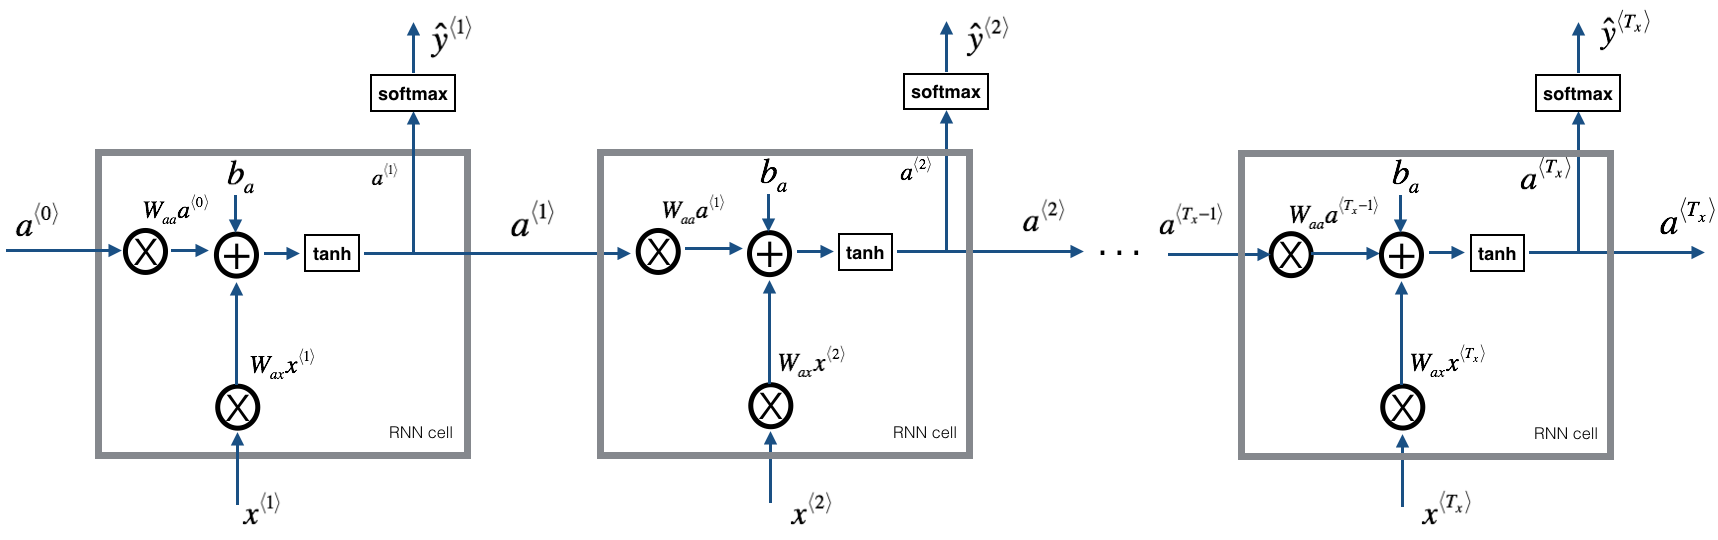

### Building blocks of the model
We will build 2 important blocks of the overall model:
1. Gradient clipping: to avoid exploding gradients
2. Sampling: a technique used to generate characters

### Clipping the gradients in the optimization loop
We will implement the clip function that will be called inside of the optimization loop.

**Exploding gradients**: when gradients are very large, they're called "exploding gradients."
Exploding gradients make the training process more difficult, because the updates may be so large that they "overshoot" the optimal values during back propagation. Recall that your overall loop structure usually consists of: (forward pass, cost computation, backward pass, parameter update). Before updating the parameters, we will perform gradient clipping to make sure that our gradients are not "exploding."

The function clip takes in a dictionary of gradients and returns a clipped version of gradients if needed.

There are different ways to clip gradients. We will use a simple element-wise clipping procedure, in which every element of the gradient vector is clipped to lie between some range [-N, N].

For example: supposed N=10, then:
* The range is [-10, 10]
* If any component of the gradient vector is greater than 10, it is set to 10
* If any component of the gradient vector is less than -10, it is set to -10
* If any components are between -10 and 10, we keep their original values

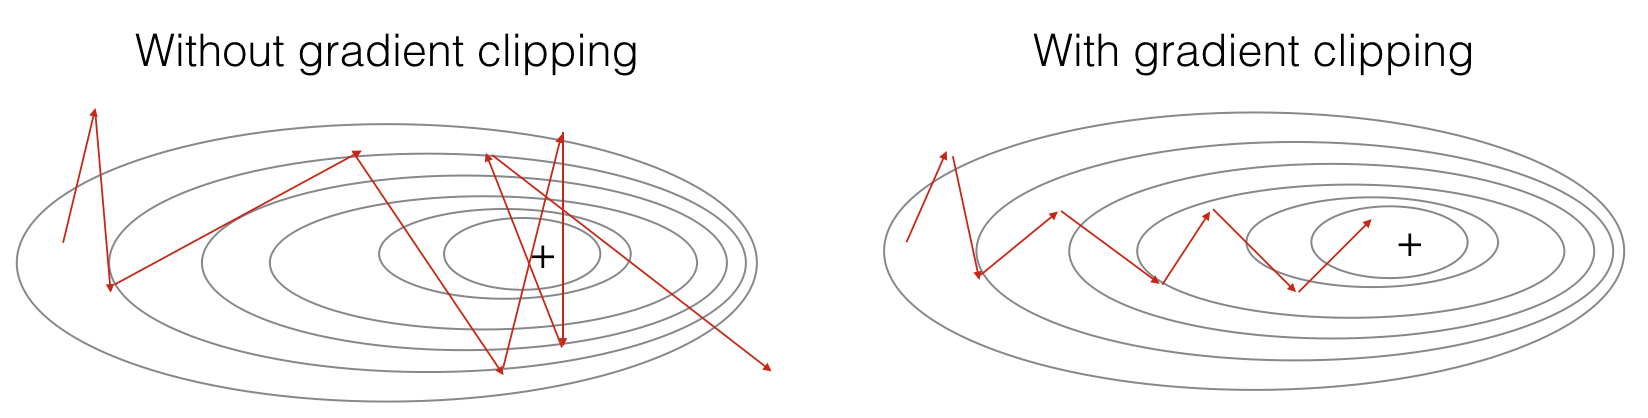

**Exercise**: Implement the clip function to return the clipped gradients

You can check out numpy.clip (you will need to use the argument "out = ...")

Using the "out" parameter allows you to update a variable "in-place"

If you don't use "out" argument, the clipped variable is stored in the variable "gradient" but does not update the gradient variables dWax, dWaa, dWya, db, dby.

In [10]:
def clip(gradients, maxValue):
    """
    Clip the gradients values between -maxValue and maxValue
    """
    dWax = gradients['dWax']
    dWaa = gradients['dWaa']
    dWya = gradients['dWya']
    db = gradients['db']
    dby = gradients['dby']
    for grads in [dWax, dWaa, dWya, db, dby]:
        np.clip(grads, -maxValue, maxValue, out=grads)

    gradients = {'dWax': dWax, 'dWaa': dWaa, 'dWya': dWya, 'db': db, 'dby': dby}
    return gradients

### Sampling
Assume that the model is trained. We would like to generate new text (characters). The process of generation is explained in the picture below:

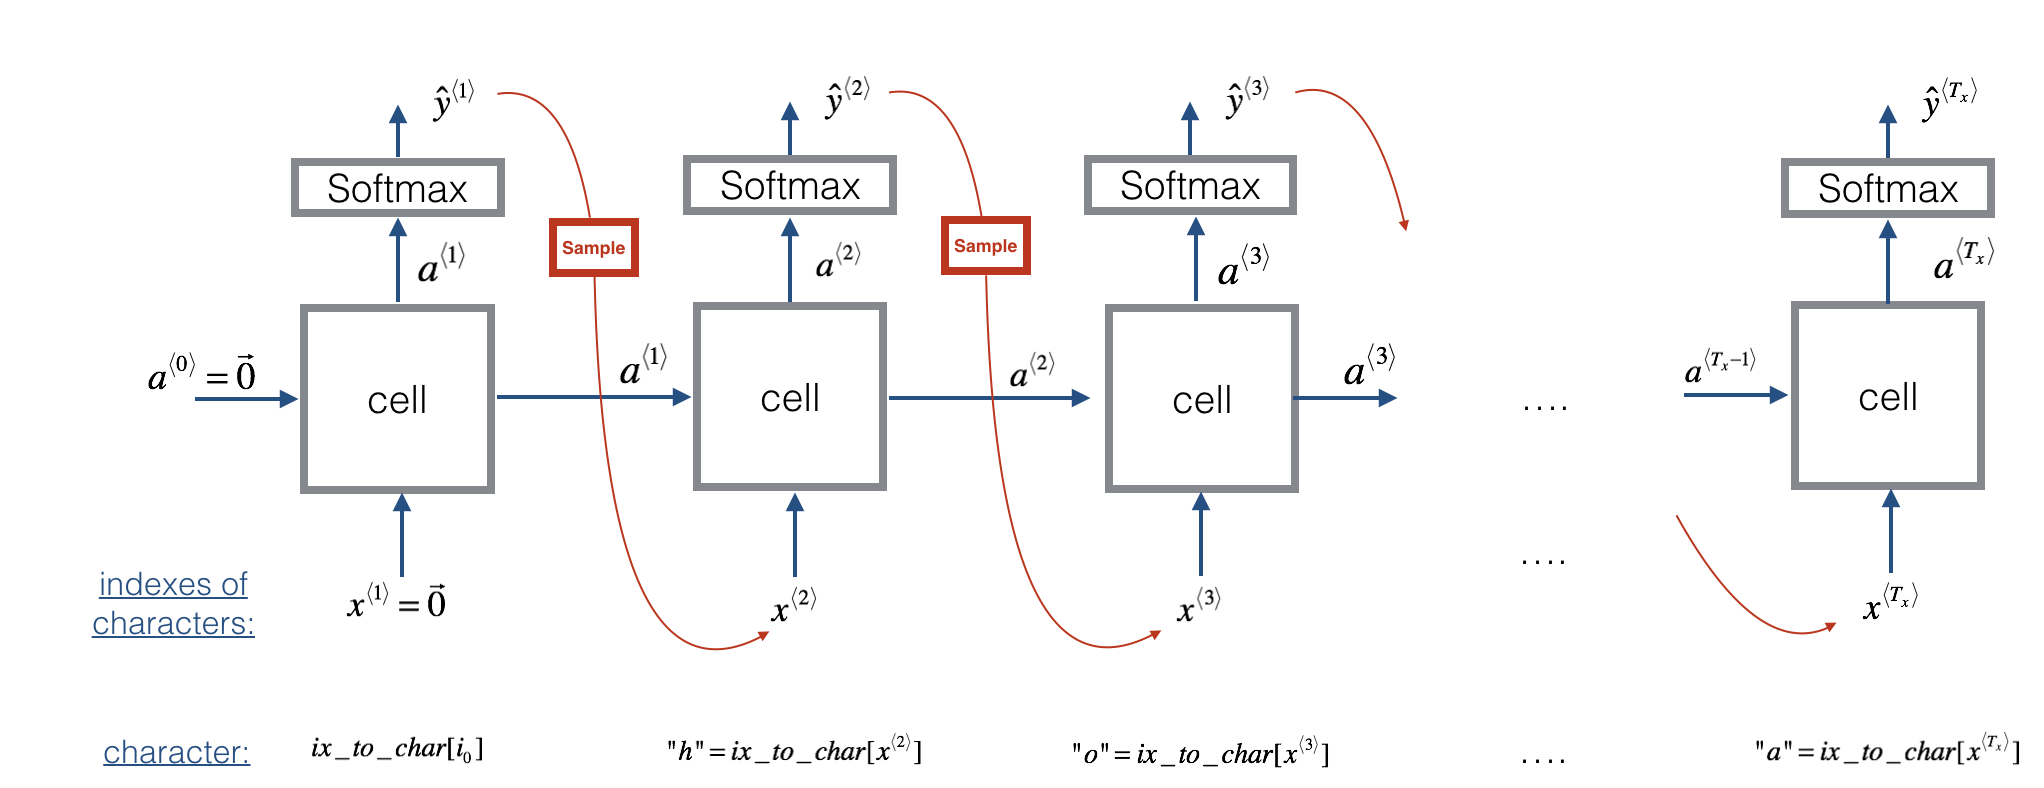

We pass in $x^{\langle 1\rangle} = \vec{0}$  at the first time step, and have the network sample one character at a time.

**Exercise**: Implement the sample function below to sample characters. We need to carry out 4 steps:

* **Step 1**: Input the "dummy" vector of zeros $x^{<1>} = \vec{0}$ (This is the default input before we generated any characters). We also set $a^{<0>} = \vec{0}$

* **Step 2**: Run one step of forward propagation to get $a^{<1>}$ and $\hat{y}^{<1>}$. Here are the equations:

**hidden state**:  
$$ a^{<t+1>} = \tanh(W_{ax}  x^{<t+1>} + W_{aa} a^{<t>} + b)$$

**activation**:
$$ z^{<t + 1>} = W_{ya}  a^{<t + 1>} + b_y$$

**prediction**:
$$ \hat{y}^{<t + 1>} = softmax(z^{<t + 1>})$$

Details about $\hat{y}^{<t + 1>}$:
   - Note that $\hat{y}^{<t + 1>}$ is a (softmax) probability vector (its entries are between 0 and 1 and sum to 1). 
   - $\hat{y}^{<t + 1>}_i$ represents the probability that the character indexed by "i" is the next character.  
   - We have provided a `softmax()` function that you can use.

### Additional Hints
- $x^{<1>}$ is `x` in the code. When creating the one-hot vector, make a numpy array of zeros, with the number of rows equal to the number of unique characters, and the number of columns equal to one.  It's a 2D and not a 1D array.
- $a^{<0>}$ is `a_prev` in the code.  It is a numpy array of zeros, where the number of rows is $n_{a}$, and number of columns is 1.  It is a 2D array as well.  $n_{a}$ is retrieved by getting the number of columns in $W_{aa}$ (the numbers need to match in order for the matrix multiplication $W_{aa}a^{<t>}$ to work.

### Using 2D arrays instead of 1D arrays
* You may be wondering why we emphasize that $x^{\langle 1 \rangle}$ and $a^{\langle 0 \rangle}$ are 2D arrays and not 1D vectors.
* For matrix multiplication in numpy, if we multiply a 2D matrix with a 1D vector, we end up with with a 1D array.
* This becomes a problem when we add two arrays where we expected them to have the same shape.
* When two arrays with  a different number of dimensions are added together, Python "broadcasts" one across the other.
* Here is some sample code that shows the difference between using a 1D and 2D array.

In [39]:
matrix1 = np.array([[1, 1],[2, 2],[3, 3]])    # (3,2)
matrix2 = np.array([[0], [0], [0]])           # (3,1) 
vector1D = np.array([1, 1])                   # (2,) 
vector2D = np.array([[1], [1]])               # (2,1)
print("matrix1 \n", matrix1,"\n")
print("matrix2 \n", matrix2,"\n")
print("vector1D \n", vector1D,"\n")
print("vector2D \n", vector2D)

matrix1 
 [[1 1]
 [2 2]
 [3 3]] 

matrix2 
 [[0]
 [0]
 [0]] 

vector1D 
 [1 1] 

vector2D 
 [[1]
 [1]]


In [40]:
print("Multiply 2D and 1D arrays: result is a 1D array\n", 
      np.dot(matrix1, vector1D))
print("Multiply 2D and 2D arrays: result is a 2D array\n", 
      np.dot(matrix1, vector2D))

Multiply 2D and 1D arrays: result is a 1D array
 [2 4 6]
Multiply 2D and 2D arrays: result is a 2D array
 [[2]
 [4]
 [6]]


In [41]:
print("Adding (3 x 1) vector to a (3 x 1) vector is a (3 x 1) vector\n",
      "This is what we want here!\n", 
      np.dot(matrix1, vector2D) + matrix2)

Adding (3 x 1) vector to a (3 x 1) vector is a (3 x 1) vector
 This is what we want here!
 [[2]
 [4]
 [6]]


In [42]:
print("Adding a (3,) vector to a (3 x 1) vector\n",
      "broadcasts the 1D array across the second dimension\n",
      "Not what we want here!\n",
      np.dot(matrix1, vector1D) + matrix2)

Adding a (3,) vector to a (3 x 1) vector
 broadcasts the 1D array across the second dimension
 Not what we want here!
 [[2 4 6]
 [2 4 6]
 [2 4 6]]


**Step 3**: Sampling: 
* Now that we have $y^{<t+1>}$, we want to select the next letter in the dinosaur name. If we select the most probable, the model will always generate the same result given a starting letter. To make the results more interesting, we will use np.random.choice to select a next letter that is likely, but not always the same.
* Sampling is the selection of a value from a group of values, where each value has a probability of being picked. 
*  Sampling allows us to generate random sequences of values.
*  Pick the next character's index according to the probability distribution specified by $\hat{y}^{<t+1>}$
    * This means that if $\hat{y}^{<t+1>}_i = 0.16$, you will pick the index "i" with 16% probability. 

Example of how to use `np.random.choice()`:
```python
np.random.seed(0)
probs = np.array([0.1, 0.0, 0.7, 0.2])
idx = np.random.choice([0, 1, 2, 3], p=probs)
```

This means that you will pick the index (`idx`) according to the distribution: 
$P(index = 0) = 0.1, \; P(index = 1) = 0.0, \; P(index = 2) = 0.7, \; P(index = 3) = 0.2$

**Note** that the value that is set to `p` should be set to a 1D vector. Also notice that $\hat{y}^{<t+1>}$, which is `y` in the code, is a 2D array.

### Additional Hints
- [numpy.ravel](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ravel.html) takes a multi-dimensional array and returns its contents inside of a 1D vector.

In [43]:
arr = np.array([[1, 2], [3, 4]])
print("arr")
print(arr)
print("arr.ravel()")
print(arr.ravel())

arr
[[1 2]
 [3 4]]
arr.ravel()
[1 2 3 4]


**Step 4**: Update to $x^{<t>}$ 
* The last step to implement in `sample()` is to update the variable `x`, which currently stores $x^{<t>}$, with the value of $x^{<t + 1>}$. 
* We will represent $x^{<t + 1>}$ by creating a one-hot vector corresponding to the character that you have chosen as your prediction. 
* We will then forward propagate $x^{< t + 1>}$ in Step 1 and keep repeating the process until we get a "\n" character, indicating that you have reached the end of the dinosaur name.

### Additional Hints
In order to reset `x` before setting it to the new one-hot vector, you'll want to set all the values to zero.
* We can either create a new numpy array: `numpy.zeros`
* Or fill all values with a single number: `numpy.ndarray.fill`

In [11]:
def sample(params, char_to_idx, seed):
    """
    Sample a sequence of characters according to a sequence of probability distribution output of the RNN
    Arguments:
    params: dictionary containing the parameters Waa, Wax, Wya, by, b 
    char_to_ix:  dictionary mapping each character to an index
    seed: for grading purposes
    Returns:
    indices: a list of length n containing indices of the sampled characters
    """
    Waa, Wax, Wya, by, b = params['Waa'], params['Wax'], params['Wya'], params['by'], params['b']
    vocab_size = by.shape[0]
    n_a = Waa.shape[1]

    # step 1: create a zero vector x that can be used as the one-hot vector, representing
    # the 1st character (initializing the sequence generation), also initialize a_prev as zero vector
    x = np.zeros((vocab_size, 1))
    a_prev = np.zeros((n_a, 1))

    # Create an empty list of indices, which will contain indices of the characters to generate
    indices = []

    # idx is a flag to detect a newline character, we initialize it to -1
    idx = -1

    # loop over time-steps t, at each time-step: sample a character from a probability distribution, and 
    # append its index to indices. We'll stop if we reach 50 characters (which should be very unlikely
    # with a well-trained model).
    counter = 0
    newline_char = char_to_idx['\n']    # this is index 0
    while (idx != newline_char and counter != 50):
        # step 2: forward propagate x
        a = np.tanh(np.dot(Wax, x) + np.dot(Waa, a_prev) + b)
        z = np.dot(Wya, a) + by
        y = softmax(z)

        np.random.seed(counter + seed)    # for grading purposes
        
        # step 3: sample the index of a character within the vocabulary from the probability distribution y
        idx = np.random.choice(list(range(vocab_size)), p=y.ravel())
        indices.append(idx)

        # step 4: overwrite the input character as the one corresponding to the sampled index
        #print('x before setting to zeros', x)
        x = np.zeros((vocab_size, 1))
        x[idx] = 1
        a_prev = a
        seed += 1
        counter += 1

    if (counter == 50):
        indices.append(char_to_idx['\n'])
    
    return indices

In [12]:
np.random.seed(2)
_, n_a = 20, 100
Wax, Waa, Wya = np.random.randn(n_a, vocab_size), np.random.randn(n_a, n_a), np.random.randn(vocab_size, n_a)
b, by = np.random.randn(n_a, 1), np.random.randn(vocab_size, 1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b, "by": by}

indices = sample(parameters, char_to_ix, 0)
print("Sampling:")
print("list of sampled indices:\n", indices)
print("list of sampled characters:\n", [ix_to_char[i] for i in indices])

Sampling:
list of sampled indices:
 [12, 17, 24, 14, 13, 9, 10, 22, 24, 6, 13, 11, 12, 6, 21, 15, 21, 14, 3, 2, 1, 21, 18, 24, 7, 25, 6, 25, 18, 10, 16, 2, 3, 8, 15, 12, 11, 7, 1, 12, 10, 2, 7, 7, 0]
list of sampled characters:
 ['l', 'q', 'x', 'n', 'm', 'i', 'j', 'v', 'x', 'f', 'm', 'k', 'l', 'f', 'u', 'o', 'u', 'n', 'c', 'b', 'a', 'u', 'r', 'x', 'g', 'y', 'f', 'y', 'r', 'j', 'p', 'b', 'c', 'h', 'o', 'l', 'k', 'g', 'a', 'l', 'j', 'b', 'g', 'g', '\n']


## Building the Language Model
Now let's build the character-level language model for text generation.

### Gradient Descent
* In this section we will implement a function performing one step of stochastic gradient descent (with clipped gradients)
* We will go through the training examples one at a time, so the optimization algorithm will be stochastic gradient descent
  
As a reminder, here are the steps of a common optimization loop for an RNN:
* Forward propagate through the RNN to compute the loss
* Backward propagate through time to compute the gradients of the loss with respect to the parameters
* Clip the gradients
* Update the parameters using gradient descent

**parameters**

* Note that the weights and biases inside the parameters dictionary are being updated by the optimization, even though parameters is not one of the returned values of the optimize function. The parameters dictionary is passed by reference into the function, so changes to this dictionary are making changes to the parameters dictionary even when accessed outside of the function.

* Python dictionaries and lists are "pass by reference", which means that if you pass a dictionary into a function and modify the dictionary within the function, this changes that same dictionary (it's not a copy of the dictionary).

**Exercise**: Implement the optimization process (one step of stochastic gradient descent)

In [13]:
def optimize(X, Y, a_prev, params, lr=0.01):
    """
    Implement one step of stochastic gradient descent to train the model
    Arguments:
    X: list of integers, where each integer is a number that maps to a character in the vocabulary
    Y: list of integers, exactly the same as X, but shifted one index to the left
    a_prev: previous hidden state
    params: dictionary containing:
                Wax: Weight matrix multiplying the input, of shape (n_a, n_x)
                Waa: Weight matrix multiplying the hidden state, of shape (n_a, n_a)
                Wya: Weight matrix relating the hidden-state to the output, of shape (n_y, n_a)
                b  : Bias, of shape (n_a, 1)
                by : Bias relating the hidden-state to the output, of shape (n_y, 1)
    lr: learning rate for the model
    Returns:
    loss: value of the loss function (cross-entropy)
    grads: dictionary containing:
                dWax: Gradients of input-to-hidden weights, of shape (n_a, n_x)
                dWaa: Gradients of hidden-to-hidden weights, of shape (n_a, n_a)
                dWya: Gradients of hidden-to-output weights, of shape (n_y, n_a)
                db  : Gradients of bias vector, of shape (n_a, 1)
                dby : Gradients of output bias vector, of shape (n_y, 1)
    a[len(X)-1]: the last hidden state, of shape (n_a, 1)
    """
    # forward propagate through time
    loss, cache = rnn_forward(X, Y, a_prev, params)   # cache contains 3 dictionaries (y_hat, a, x)

    # backpropagate through time
    grads, a = rnn_backward(X, Y, params, cache)

    # clip gradients between -5 and 5
    grads = clip(grads, 5)

    params = update_parameters(params, grads, lr)

    return loss, grads, a[len(X)-1]

In [14]:
np.random.seed(1)
vocab_size, n_a = 27, 100
a_prev = np.random.randn(n_a, 1)
Wax, Waa, Wya = np.random.randn(n_a, vocab_size), np.random.randn(n_a, n_a), np.random.randn(vocab_size, n_a)
b, by = np.random.randn(n_a, 1), np.random.randn(vocab_size, 1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b, "by": by}
X = [12, 3, 5, 11, 22, 3]
Y = [4, 14, 11, 22, 25, 26]

loss, gradients, a_last = optimize(X, Y, a_prev, parameters, lr = 0.01)
print("Loss =", loss)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("np.argmax(gradients[\"dWax\"]) =", np.argmax(gradients["dWax"]))
print("gradients[\"dWya\"][1][2] =", gradients["dWya"][1][2])
print("gradients[\"db\"][4] =", gradients["db"][4])
print("gradients[\"dby\"][1] =", gradients["dby"][1])
print("a_last[4] =", a_last[4])

Loss = 126.50397572165379
gradients["dWaa"][1][2] = 0.1947093153472057
np.argmax(gradients["dWax"]) = 93
gradients["dWya"][1][2] = -0.007773876032003775
gradients["db"][4] = [-0.06809825]
gradients["dby"][1] = [0.01538192]
a_last[4] = [-1.]


## Training the model
* Given the data of dinosaur names, we use each line of the data (one name) as one training example
* Every 100 steps of stochastic gradient descent, we will sample 10 randomly chosen names to see how the algorithm is doing
* Remember to shuffle the data, so that stochastic gradient descent visits the examples in random order

**Set the index `idx` into the list of examples**
* Using the for-loop, walk through the shuffled list of dinosaur names in the list examples
* If there are 100 examples, the for-loop increments the index to 100 onwards. Think of how you would make the index cycle back to 0, so that we can continue feeding the examples into the model when j is 100, 101, etc
* Hint: use modulus operator (%). 101 divided by 100 is zero with a remainder of 1

**Extract a single example from the list of examples**
* `single example`: use the `idx` index that we set previously to get one word from the list of examples

**Convert a string into a list of characters**: `single_example_chars`
* `single_example_chars`: a string, is a list of characters
* We can use a list comprehension (recommended over for-loops) to generate a list of characters:

In [152]:
str = 'I love learning'
[c for c in str]

['I', ' ', 'l', 'o', 'v', 'e', ' ', 'l', 'e', 'a', 'r', 'n', 'i', 'n', 'g']

**Convert list of characters to a list of integers**: `single_example_ix`
* Create a list that contains the index number associated with each character
* Use the dictionary char_to_ix
* We can combine this with the list comprehension that is used to get a list of characters from a string

**Create the list of input characters**: `X`
* `rnn_forward` uses the `None` value as a flag to set the input vector as a zero-vector
* Prepend the `None` value in front of the list of input characters
* Theres is more than one way to prepend a value to a list. One way is to add two lists together: ['a'] + ['b']

**Get the integer representation of the newline character**: `ix_newline` (use char_to_ix)
* `ix_newline`: the newline character signals the end of the dinosaur name

**Set the list of labels (integer representation of the characters)**: `Y`
* The goal is to train the RNN to predict the next letter in the name, so the labels are the list of characters that are one time step ahead of the characters in the input X. For example: `Y[0]` contains the same value as `X[1]`
* The RNN should predict a newline at the last letter, so add ix_newline to the end of the labels (append the integer representation of the newline character to the end of `Y`).

**Note**: append is an in-place operation. It might be easier to add two lists together

**Finally**: When examples[index] contains one dinosaur name (string), to create an example (X, Y):
```Python
# examples[:3] = ['aachenosaurus', 'aardonyx', 'abdallahsaurus']
for j in range(n_iters):        # n_iters = 35000
    index = j % len(examples)   # len(examples) = 1536
    X = [None] + [char_to_ix[c] for c in examples[index]]
    Y = X[1:] + [char_to_ix['\n']]
```
Note that the first entry of X being `None` will be interpreted by `rnn_forward()` as setting $x^{<0>} = \vec{0}$. Further, this ensures that `Y` is equal to `X` but shifted one step to the left, and with an additional '\n' appended to signify the end of the dinosaur name.

In [32]:
def model(data, ix_to_char, char_to_ix, n_iters=35000, n_a=50, dino_names=7, vocab_size=27):
    """
    Trains the model and generates dinosaur names
    Arguments:
    data: text corpus
    n_a: number of units in the RNN cell
    dino_names: number of dinosaur names we want to sample at each iteration
    vocab_size: number of unique characters found in the text (size of the vocabulary)
    Returns: params: learned parameters
    """
    n_x, n_y = vocab_size, vocab_size
    params = initialize_parameters(n_a, n_x, n_y)

    # initialize loss (this is required because we want to smooth our loss)
    loss = get_initial_loss(vocab_size, dino_names)

    # build a list of all dinosaur names (training examples)
    with open('dinos.txt') as f:
        examples = f.readlines()
    examples = [x.lower().strip() for x in examples]

    # shuffle the list
    np.random.seed(0)
    np.random.shuffle(examples)

    # initialize the hidden state of our LSTM
    a_prev = np.zeros((n_a, 1))

    # optimization loop
    for j in range(n_iters):
        idx = j % len(examples)
        X = [None] + [char_to_ix[ch] for ch in examples[idx]] 
        Y = X[1:] + [char_to_ix["\n"]]
        
        # Perform one optimization step: Forward-prop -> Backward-prop -> Clip -> Update parameters
        # Choose a learning rate of 0.01
        curr_loss, gradients, a_prev = optimize(X, Y, a_prev, params)        
        
        # Use a latency trick to keep the loss smooth. It happens here to accelerate the training.
        loss = smooth(loss, curr_loss)

        # Every 2000 Iteration, generate "n" characters thanks to sample() to check if the model is learning properly
        if j % 2000 == 0:
            
            print('Iteration: %d, Loss: %f' % (j, loss) + '\n')
            
            # The number of dinosaur names to print
            seed = 0
            for name in range(dino_names):            
                # Sample indices and print them
                sampled_indices = sample(params, char_to_ix, seed)
                print_sample(sampled_indices, ix_to_char)
                
                seed += 1  # To get the same result (for grading purposes), increment the seed by one.     
            print('\n')     
    return parameters

Run the following cell, you should observe your model outputting random-looking characters at the first iteration. After a few thousand iterations, your model should learn to generate reasonable-looking names.

In [33]:
parameters = model(data, ix_to_char, char_to_ix)

Iteration: 0, Loss: 23.087336

Nkzxwtdmfqoeyhsqwasjkjvu
Kneb
Kzxwtdmfqoeyhsqwasjkjvu
Neb
Zxwtdmfqoeyhsqwasjkjvu
Eb
Xwtdmfqoeyhsqwasjkjvu


Iteration: 2000, Loss: 27.884160

Liusskeomnolxeros
Hmdaairus
Hytroligoraurus
Lecalosapaus
Xusicikoraurus
Abalpsamantisaurus
Tpraneronxeros


Iteration: 4000, Loss: 25.901815

Mivrosaurus
Inee
Ivtroplisaurus
Mbaaisaurus
Wusichisaurus
Cabaselachus
Toraperlethosdarenitochusthiamamumamaon


Iteration: 6000, Loss: 24.608779

Onwusceomosaurus
Lieeaerosaurus
Lxussaurus
Oma
Xusteonosaurus
Eeahosaurus
Toreonosaurus


Iteration: 8000, Loss: 24.070350

Onxusichepriuon
Kilabersaurus
Lutrodon
Omaaerosaurus
Xutrcheps
Edaksoje
Trodiktonus


Iteration: 10000, Loss: 23.844446

Onyusaurus
Klecalosaurus
Lustodon
Ola
Xusodonia
Eeaeosaurus
Troceosaurus


Iteration: 12000, Loss: 23.291971

Onyxosaurus
Kica
Lustrepiosaurus
Olaagrraiansaurus
Yuspangosaurus
Eealosaurus
Trognesaurus


Iteration: 14000, Loss: 23.382338

Meutromodromurus
Inda
Iutroinatorsaurus
Maca
Yusteratop

### Conclusion
You can see that your algorithm has started to generate plausible dinosaur names towards the end of the training. At first, it was generating random characters, but towards the end you could see dinosaur names with cool endings. Feel free to run the algorithm even longer and play with hyperparameters to see if you can get even better results. Our implementation generated some really cool names like maconucon, marloralus and macingsersaurus. Your model hopefully also learned that dinosaur names tend to end in saurus, don, aura, tor, etc.

If your model generates some non-cool names, don't blame the model entirely--not all actual dinosaur names sound cool. (For example, dromaeosauroides is an actual dinosaur name and is in the training set) But this model should give you a set of candidates from which you can pick the coolest!

This assignment had used a relatively small dataset, so that you could train an RNN quickly on a CPU. Training a model of the english language requires a much bigger dataset, and usually needs much more computation, and could run for many hours on GPUs. We ran our dinosaur name for quite some time, and so far our favorite name is the great, undefeatable, and fierce: Mangosaurus!